# Problem 1 (40 points)

The following table contains the estimated bulk mass densities as a function of depth for an offshore location in Brazil. Water depth is 500m. Measurements indicate that porosity of shale layers estimated through resistivity measurements.

|Depth (m)| Bulk mass density (kg/m$^3$) | Shale porosity |
|:-------:|:-------------------------:|:--------------:|
| 0   | 1025 | | 
| 100 | 1026 | |
| 200 | 1026 | |
| 300 | 1030 | |
| 400 | 1030 | |
| 500 | 1031 | |
| 600 | 1900 | |
| 700 | 2190 | |
| 800 | 2200 | |
| 900 | 2230 | |
| 1000| 2235 | |
| 1100| 2240 | |
| 1200| 2275 | 0.305 |
| 1300| 2305 | 0.297 |
| 1400| 2310 | 0.286 |
| 1500| 2308 | 0.281 |
| 1600| 2310 | 0.285 |
| 1700| 2305 | 0.293 |
| 1800| 2310 | 0.307 |
| 1900| 2324 | 0.305 |
| 2000| 2319 | 0.298 |


 a. Plot $S_v$ as a function of depth (in SI units)

 b. Plot hydrostatic water pressure as a function of depth. Assume the density of brine water is 1031 kg/m$^3$
in the rock pore space (in SI units).

 c. Additional compaction lab measurements on shale cores indicate a good fit of the porosity-effective vertical stress relation through the equation $\phi = \phi_0 \exp(-\beta (S_v - P_p))$, with parameters $\phi_0=0.38$ and $\beta = 3 \cdot 10^{-2}$ MPa$^{-1}$. Estimate the pore pressure in the shale. Is there overpressure? At what depth does it start?

 d. Plot vertical effective strees, $\sigma_v^{eff}$ as a function of depth (in SI units).

**Solution**

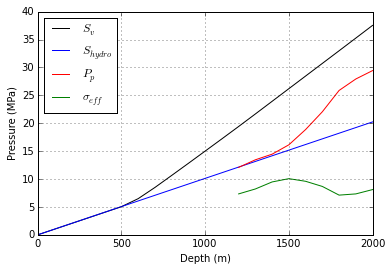

In [1]:
import numpy as np
from scipy import integrate
import scipy.optimize

%matplotlib inline
import matplotlib.pyplot as plt

#Input data
depth = np.linspace(0, 2000, num=21)
density = np.array([1025, 1026, 1026, 1030, 1030, 1031, 1900, 2190, 
                    2200, 2230, 2235, 2240, 2275, 2305, 2310, 2308, 
                    2310, 2305, 2310, 2323, 2319])
density_brine = 1031. * np.ones_like(density)
porosity = np.array([0.305, 0.297, 0.286, 0.281, 0.285, 0.293, 0.307, 0.305, 0.298])

#Compute S_v
Sv = integrate.cumtrapz(density * 9.81, depth, initial=0)
#Compute S_hydro
hydro = integrate.cumtrapz(density_brine * 9.81, depth, initial=0)
#Compute P_p
phi_0 = 0.38
beta = 3e-2 / (1e6)
Pp = Sv[-len(porosity):] + (1. / beta) * np.log(porosity / phi_0)
#Compute sigma_eff
sigma_eff = Sv[-len(porosity):] - Pp
#Create plot
plt.plot(depth, Sv / 1e6, 'k', label="$S_v$") 
plt.plot(depth, hydro / 1e6, 'b', label="$S_{hydro}$") 
plt.plot(depth[-(len(porosity)):], Pp / 1e6, 'r', label="$P_p$")
plt.plot(depth[-(len(porosity)):], sigma_eff / 1e6, 'g', label="$\sigma_{eff}$");
plt.grid()
plt.legend(loc=2)
plt.xlabel("Depth (m)")
plt.ylabel("Pressure (MPa)");

Below are the depths at which there is an overpressure.

In [2]:
depth[-(len(porosity)):][Pp > hydro[-(len(porosity)):]]

array([ 1300.,  1400.,  1500.,  1600.,  1700.,  1800.,  1900.,  2000.])

So the overpressure starts at between 1200 and 1300 meters.

# Problem 2 (20 points)

Compare the characteristic hydraulic time of escape in a sandstone formation with porosity 0.25 and the one with the same matrix grains, but more compacted, with porosity 0.12.

 * You can assume that permeability can be estimated using equation $k = C d^2 \phi^3$ where $C$ is a given constant, $d$ is sandstone grain diameter and $\phi$ is porosity. When using the formula, assume that constant $C$ and grain diameter $d$ do not change during compaction. Compressibility $\beta$ of a material is inverse of its bulk modulus $K$. Bulk modulus for brine water and quartz grains are given as $K_f=2.2$ GPa and $K_r=41$ GPa.

**Solution**

We'll make the comparison through utilizing a ratio of the two characteristic hydraulic times.

In [3]:
tau_ratio = ((0.12 * (1. / 2.2e9) + (1. / 41e9)) / 
             0.12 ** 3.0) / ((0.25 * (1. / 2.2e9) + (1. / 41e9)) / 0.25 ** 3.0); tau_ratio

5.1711475531756665

Therefore, the more compacted sandstone formation with a porosity of $0.12$ will have a characteristic hydraulic time that is $5.2$ times longer than the sandstone with a porosity value of $0.25$.

# Problem 3 (30 points)

Assume stresses are given as $S_{hmin}=40$ MPa, $S_{Hmax}$=60 MPa, $S_{v}$=45 MPa and $S_{hmin}$ acts in the East-West direction. For each of the faults below, calculate the normal and shear stress and then determine what kind of fault would it be, if it were to slip.
 
 a. Fault with strike north-south, dip 65$^\circ$ to the east.
 
 b. Fault with strike north-south, dip 50$^\circ$ to the west
 
 c. Fault with strike east-west, dip 25$^\circ$ to the north.

**Solution**

First we need to order the stresses in terms of the principle stress definitions, i.e. $S_1 = S_{Hmax}$, $S_2 = S_v$, and $S_3 = S{hmin}$.  With this ordering, we can see that we need to rotate by $\gamma = 90^{\circ}$ to align $S_v$ down and $S_{hmin}$ with the East-West direction.  First we define a function to calculate the rotation matrix and compute $S_G$.

In [4]:
def compute_Sg(S, angles=(0,0,0)):
    
    alpha, beta, gamma = np.radians(angles)
    
    Rg = np.array([[np.cos(alpha) * np.cos(beta),  
                    np.sin(alpha) * np.cos(beta),  
                    -np.sin(beta)],
                   [np.cos(alpha) * np.sin(beta) * np.sin(gamma) - np.sin(alpha) * np.cos(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.sin(gamma) + np.cos(alpha) * np.cos(gamma),  
                    np.cos(beta) * np.sin(gamma)],
                   [np.cos(alpha) * np.sin(beta) * np.cos(gamma) + np.sin(alpha) * np.sin(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.cos(gamma) - np.cos(alpha) * np.sin(gamma),  
                    np.cos(beta) * np.cos(gamma)]])
                  
    return np.dot(Rg.T, np.dot(S,Rg))

In [5]:
S = np.diag([60, 45, 40])

S_G = compute_Sg(S, angles=(0,0,90)); S_G

array([[  6.00000000e+01,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.00000000e+01,   3.06161700e-16],
       [  0.00000000e+00,   3.06161700e-16,   4.50000000e+01]])

Now we'll define a function that will compute the unit vectors for us.

In [6]:
def compute_unit_vectors(strike, dip):
    
    strike = np.radians(strike)
    dip = np.radians(dip)
    
    n = np.array([-np.sin(strike) * np.sin(dip), np.cos(strike) * np.sin(dip), -np.cos(dip) ])
    
    ns = np.array([ np.cos(strike), np.sin(strike), 0 ])
    
    nd = np.array([ -np.sin(strike) * np.cos(dip), np.cos(strike) * np.cos(dip), np.sin(dip) ])
    
    return (n, ns, nd)

With this we can easily compute the anwers to the following scenerios.

**a) $strike = 60^{\circ}, dip = 65^{\circ}$**

In [7]:
n, ns, nd = compute_unit_vectors(0, 65); 
print(n)
print(ns)
print(nd)

[-0.          0.90630779 -0.42261826]
[ 1.  0.  0.]
[-0.          0.42261826  0.90630779]


Now we compute the normal and shear stresses on the plane

In [8]:
sigma_n = np.dot(np.dot(S_G, n), n); sigma_n

40.893030975783645

In [9]:
tau_s = np.dot(np.dot(S_G, n), ns); tau_s

0.0

In [10]:
tau_d = np.dot(np.dot(S_G, n), nd); tau_d

-1.9151111077974452

In this case, there is only a shear stress in direction of the dip.  This is the shear stress on the footwall as defined, therefore the hanging wall will have a shear stress in the opposite direction (opposing motion) such that the hanging wall will move in the direction of the shear stress on the footwall.  Therefore, the motion of the hanging wall will be *up* the footwall.  **This is a reverse fault**.

**b)** $strike = 180^{\circ}, dip = 50^{\circ}$

In [11]:
n, ns, nd = compute_unit_vectors(180, 55); 
print(n)
print(ns)
print(nd)

[ -1.00317193e-16  -8.19152044e-01  -5.73576436e-01]
[ -1.00000000e+00   1.22464680e-16   0.00000000e+00]
[ -7.02428547e-17  -5.73576436e-01   8.19152044e-01]


In [12]:
sigma_n = np.dot(np.dot(S_G, n), n); sigma_n

41.644949641685827

In [13]:
tau_s = np.dot(np.dot(S_G, n), ns); tau_s

2.0063438581070496e-15

In [14]:
tau_d = np.dot(np.dot(S_G, n), nd); tau_d

-2.3492315519647704

Following the same logic as above, **this is a reverse fault**.

**c)** $strike = 270^{\circ}, dip = 25^{\circ}$

In [15]:
n, ns, nd = compute_unit_vectors(270, 25); 
print(n)
print(ns)
print(nd)

[  4.22618262e-01  -7.76337152e-17  -9.06307787e-01]
[ -1.83697020e-16  -1.00000000e+00   0.00000000e+00]
[  9.06307787e-01  -1.66486040e-16   4.22618262e-01]


In [16]:
sigma_n = np.dot(np.dot(S_G, n), n); sigma_n

47.679092927350951

In [17]:
tau_s = np.dot(np.dot(S_G, n), ns); tau_s

-1.2751975718967087e-15

In [18]:
tau_d = np.dot(np.dot(S_G, n), nd); tau_d

5.7453333233923374

Following the same logic as explained in a), **this is a normal fault**.

# Problem 4 (20 points)

A major fault in your reservoir has strike N35$^\circ$W and dip 60$^\circ$ from horizontal. $S_{hmin}$ in this area acts along 020$^\circ$, and in situ stresses are $S_{hmin}=70$ MPa, $S_{Hmax}=80$ MPa, $S_v=65$ MPa.   Assume the pore pressure $P_p =30$ MPa. Is the fault likely to slip if the respective frictional coefficient is $\mu=0.7$?

**Solution**

First we'll define some functions that we will use in this problem and the next.

In [19]:
def compute_stress_components_on_fault(S, strike, dip, angles=(0,0,0)):

    S_G = compute_Sg(S, angles)
    
    n, ns, nd = compute_unit_vectors(strike, dip)
    
    sigma_n = np.dot(np.dot(S_G, n), n)
    tau_s = np.dot(np.dot(S_G, n), ns)
    tau_d = np.dot(np.dot(S_G, n), nd)
    
    tau_mag = np.sqrt(tau_s ** 2. + tau_d ** 2.)
    
    return (sigma_n, tau_s, tau_d, tau_mag)


def check_fault_slip(S, Pp, strike, dip, angles=(0,0,0), mu=0.6):
    
    sigma_n, tau_s, tau_d, tau_mag = compute_stress_components_on_fault(S, strike, dip, angles)
    
    return (tau_mag / (sigma_n - Pp) > mu)

Now we can check to see if our fault is slipping under the given conditions from the funcions above.

In [20]:
S = np.diag([80, 70, 65])

check_fault_slip(S, 30, 35, 60, angles=(-70,0,0), mu=0.7)

False

# Problem 5 (40 points)

Assuming the same reservior conditions as Problem 1, write a computer code that can compute the resolved shear stress magnitude and normal effective stress on a fault characterized by the strike direction and dip angle.  Now randomly generate 10000 faults (use a statistical distribution to choose random pairs of strike and dip) and plot the results on a Mohr diagram.  Where do near vertical strike-slip faults appear on this diagram? Where do the oblique-slip faults fall?

**Solution**

The code below creates the random faults.  We will assume that a near-vertical strike-slip fault is one in which the dip angle is greater than $85^\circ$.  Oblique-slip faults are those that have near-equal magnitudes of shear and dip components of shear stresses.

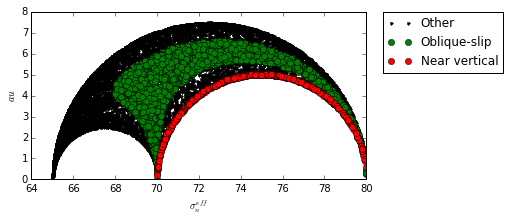

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def create_plot(S, angles=(0,0,0)):

    strikes = np.random.rand(10000) * 360
    dips =  np.random.rand(10000) * 90

    out = np.array([ compute_stress_components_on_fault(S, strikes[i], dips[i], angles) for i in range(len(strikes)) ])

    normal = out[:,0]
    shear_slip = out[:,1]
    shear_dip = out[:,2]
    shear_mag = out[:,3]


    vert_ss = np.logical_and(dips > 85, np.abs(shear_slip / shear_dip) > 5)
    oblique_slip = np.logical_and(0.75 < np.abs(shear_slip / shear_dip), np.abs(shear_slip / shear_dip) < 1.5)
    other = np.logical_not(np.logical_or(vert_ss, oblique_slip))

    plt.figure()
    plt.gca().set_aspect('equal')
    plt.plot(normal[other], shear_mag[other], 'k.',
             normal[oblique_slip], shear_mag[oblique_slip], 'go',
             normal[vert_ss], shear_mag[vert_ss], 'ro'),
    plt.xlabel('$\sigma_n^{eff}$')
    plt.ylabel('${\tau}$');
    plt.legend(['Other','Oblique-slip', 'Near vertical'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
    
    
create_plot(S, angles=(-70,0,0))

The plot above sort-of speaks for itself, there is no reason to describe in words the answers to the questions with a properly made figure.

# Problem 6 (10 points)

Repeat Problem 2 but make $S_{hmin}=S_{Hmax}=45$ MPa (i.e. stress isotropic in the horizontal plane. How has the Mohr diagram changed? Is this still a 3D problem?

**Solution**

We can use our code above to quickly solve this problem by simply plugging in the new numbers.

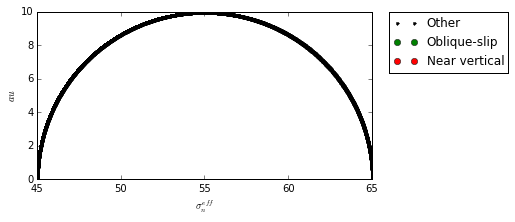

In [22]:
S = np.diag([65, 45, 45])
create_plot(S, angles=(0,-90,0))

This problem is clearly 2D as it can be fully characterized by the two principle stresses.